In [39]:
# Uncomment the pip install lines to get these packages locally installed the first time, if needed
#!pip install --user mplhep
#!pip install --user zfit

import matplotlib as mpl
import uproot
import matplotlib.pyplot as plt
import scipy
import numpy as np
import math
import pandas as pd
import seaborn as sns
import mplhep as hep
#import zfit
import inspect


plt.style.use(hep.style.ATLAS)

#print("Seaborn: " + sns.__version__)
#print("MatPlotLib: " + mpl.__version__)

plt.rcParams.update({'font.sans-serif': "Arial",
                     'font.family': "sans-serif",
                     'font.size': 30,
                     'mathtext.fontset': 'custom',
                     'mathtext.rm': 'Arial',
                     })


# EIC Studies

The goal is to study basic questions about baseline detector (or variations to the baseline detector) and its performance when altering parameters such as:

* the strength of the solenoidal bending field;
* the composition or layout of the calorimeter.

Specifically, the goal here is to address issues of:

* Jet resolution (energy, $p_T$);
* Jet efficiency
* Separation of signals from backgrounds (e.g. as a function of changing resolution)

## Installation of Core Software

These instructions are applicable to ManeFrame II at SMU, but may apply elsewhere. I recommend creating a single area to contain all code and work (e.g. ~/scratch/EIC/).

1. Install PYTHIA8
   * http://home.thep.lu.se/~torbjorn/Pythia.html
   * Download the tarball and unpack it. 
   * Configure it for local installation in your work area, e.g. ```./configure --prefix=/users/ssekula/scratch/EIC/```
   * Build it, ```make -j```
   * Install it, ```make install```
   * Make sure the work area binary directory is in your PATH: ```PATH=/users/ssekula/scratch/EIC/bin:${PATH}```
1. Install Delphes
   * https://github.com/delphes/delphes
   * Clone the project and make sure you are on the master branch
   * Make sure ROOT is available in your path, e.g. ```lsetup "root 6.18.04-x86_64-centos7-gcc8-opt"```
   * Compile with PYTHIA8: ```HAS_PYTHIA8=true PYTHIA8=/users/ssekula/scratch/EIC ./configure --prefix=/users/ssekula/scratch/EIC/```
   * Build: ```make -j```
   * Install: ```make install```
1. Get the Delphes/EIC code for simulation and analysis of a detector baseline/configuration.
   * https://github.com/miguelignacio/delphes_EIC
   * Clone the repository locally
   * Follow the instructions to run the example and generate a ROOT file.

In [25]:
data = uproot.pandas.iterate(["../p250_B15/*/out.root"], 
                           "Delphes", 
                           branches=["Jet.PT", "Jet.Eta", "Jet.Phi", "Jet.Mass", 
                                     "GenJet.PT", "GenJet.Eta", "GenJet.Phi", "GenJet.Mass"],
                          flatten=False)
#data = uproot.lazyarrays(path=["../p250_B15/*/out.root"], 
#                           treepath="Delphes", 
#                           branches=["Jet*", "GenJet*"],
#                          flatten=False)
df_list = []
for dataframe in data:
    df_list.append(dataframe)
    
df = pd.concat(df_list)

In [26]:
# Print Column Information
#list(df)
n_events = len(df)
#print(n_events)

In [27]:
# Define histogramming/plotting functions
def hist(x, xlim, bins, label, xlabel, ylabel):
    fig, ax = plt.subplots(figsize=(8,8))
    plt.grid(which='both')
    plt.hist(x, range=xlim, bins=bins, color='b', linewidth=3, label=label)
    plt.xlim(xlim)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    #ax.set_xscale('log')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [28]:
# Add some auxiliary variables
#df['Jet.E'] = np.sqrt(df['Jet.PT']*np.cosh(df['Jet.Eta'])**2+df['Jet.Mass']**2)
def JetEnergy(row):
    JetPt = row["Jet.PT"]
    JetEta = row["Jet.Eta"]
    JetMass = row["Jet.Mass"]
    
    jet_energy = []
    
    for jet in range(len(JetPt)):
        jet_eta = JetEta[jet]
        jet_pt = JetPt[jet]
        jet_mass = JetMass[jet]
        
        jet_energy.append( np.sqrt( (jet_pt*np.cosh(jet_eta))**2 + (jet_mass)**2 )  )
        
    return jet_energy

df['Jet.E'] = df.apply(JetEnergy, axis=1)

## Monte Carlo Simulation Samples

The simulations performed here use a solenoidal magnetic field strength of 1.5T, in addition to the tracking and calorimeter performance model described below. Each variation in the detector configuration contains {{n_events}} generated e-p collisions.

## Jet Resolution Study

Given the implementation of an EIC baseline-like detector in Delphes, it is interesting to look at the jet energy resolution for jets from the process

$$e^- + p^+ \to e^- + \mathrm{jet} + X.$$

This is neutral current (NC) deep-inelastic scattering (DIS). The beam electron has an energy of 10 GeV, while the beam proton has an energy of 250 GeV. This DIS results in the production of a jet (from a struck quark) preferentially in the direction of the beam proton.

The coordinate system for the detector places $\theta=0$ - the positive $z$ axis - in the direction of the hadron beam. Thus $\eta>0$ corresponds to the direction of the hadron beam and $\eta<0$ to the direction of the electron beam. In the above CC DIS interaction, we thus expect the $\eta$ of a jet to preferentially have $\eta>0$ given the beam energy asymmetry.

Jets are reconstructed inside the Delphes framework from ```EFlowMerger``` objects using the FastJet algorithm's implementation of the Anti-$k_T$ jet reconstruction and a radius parameter $R=1$. (Note that at HERA, jets were studied over a range of radius parameters including 1.0, c.f. Jimenez, M. (2008). *Jets and $\alpha_s$ measurements in DIS at HERA*. Nuclear Physics B - Proceedings Supplements, 184(C), 109–111. http://doi.org/10.1016/j.nuclphysbps.2008.09.146) Because Energy Flow is used to compute the energy of the jet, this uses charged tracks to determine momentum in the jet where a track is available to replace a neutral object in the jet energy computation. As a result, calorimeter energy resolution issues get de-weighted in favor of track momentum resultion issues, as regards jet 4-vector behavior. 

No jet energy scale is applied to the jet candidates. A minimum $p_T$ of 5GeV is enforced for reconstructe jet objects.

Jet resolution for a jet variable $x$ (e.g. $x=$ jet energy) as:

$$\Sigma=\frac{x_{reco} - x_{true}}{x_{true}}$$

In this study, it is reported in percent. I will focus on the jet energy resolution:

$$\Sigma_{E}=\frac{E_{reco} - E_{true}}{E_{true}}$$

Experiments that study jet resolution and energy scale often refer to quantities like $p_T/p_T^{true}$ or $E/E^{true}$; the above definition is just a simple transformation of that quantity (e.g. $p_T/p_T^{true}-1$).

### Basic Jet Quantities

Below are plots showing basic jet quantities from the reconstruction: $p_T$, $m$, $\eta$, $\phi$, and $E$. DELPHES does not write jet energy to the output data file; instead, it writes $p_T$, $\eta$, and $m$ for the jet. Jet energy is inferred from

$$E = \sqrt{(p_T\cosh\eta)^2 + m^2}$$

This energy will be a mix of tracking and calorimeter inputs due to the use of energy flow to construct the jet objects.

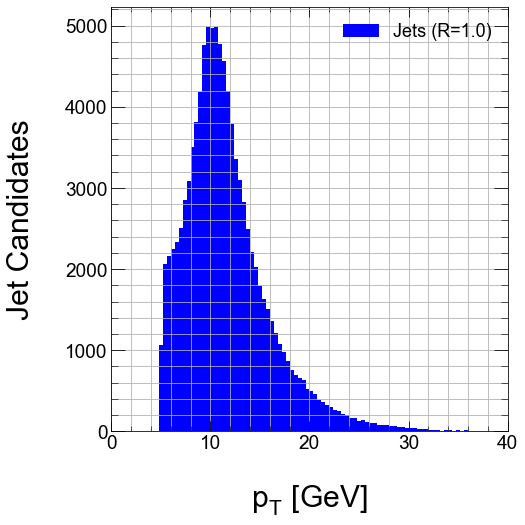

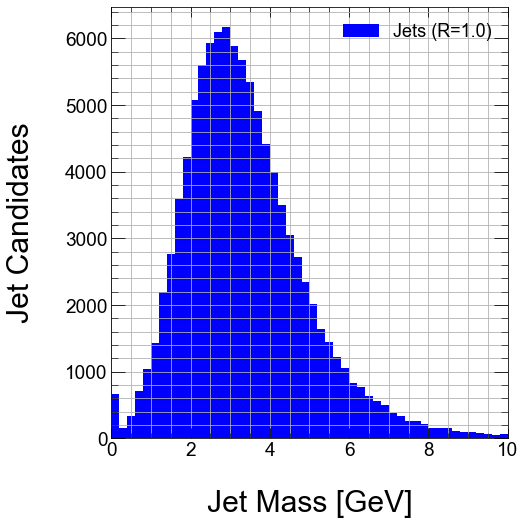

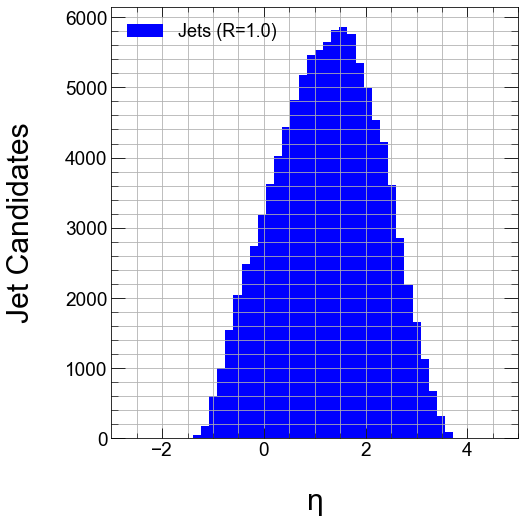

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


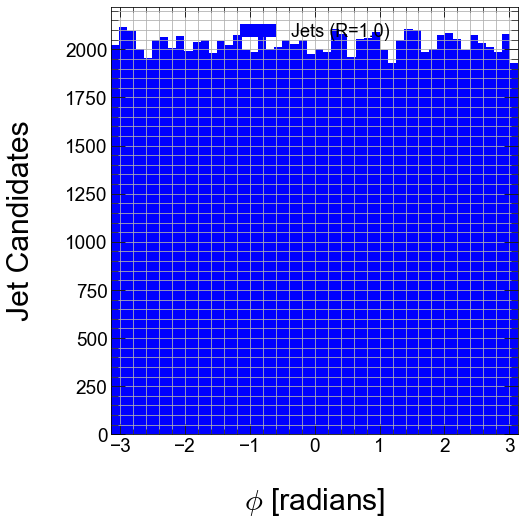

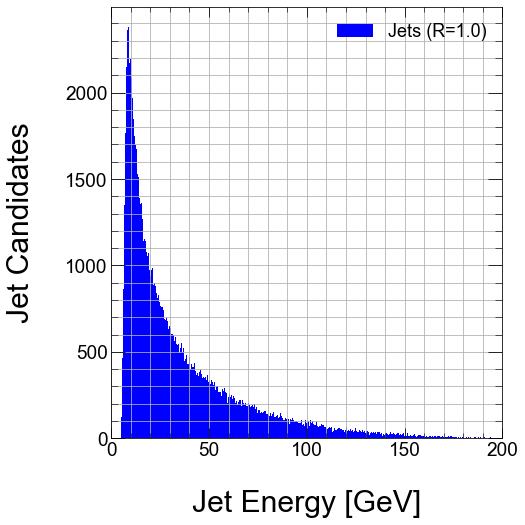

In [40]:
# Plot some basic jet information

jet_pt = np.concatenate(df['Jet.PT'].to_numpy()).ravel()
hist(jet_pt,[0,40], 100, label='Jets (R=1.0)', xlabel="$p_T$ [GeV]", ylabel="Jet Candidates")

jet_mass = np.concatenate(df['Jet.Mass'].to_numpy()).ravel()
hist(jet_mass,[0,10], 50, label='Jets (R=1.0)', xlabel="Jet Mass [GeV]", ylabel="Jet Candidates")

jet_eta = np.concatenate(df['Jet.Eta'].to_numpy()).ravel()
hist(jet_eta,[-3,5], 50, label='Jets (R=1.0)', xlabel="$\eta$", ylabel="Jet Candidates")

jet_phi = np.concatenate(df['Jet.Phi'].to_numpy()).ravel()
hist(jet_phi,[-math.pi,math.pi], 50, label='Jets (R=1.0)', xlabel="$\phi$ [radians]", ylabel="Jet Candidates")

# Construct jet energy from the above
jet_energy = np.concatenate(df['Jet.E'].to_numpy()).ravel()
hist(jet_energy,[0,200], 400, label='Jets (R=1.0)', xlabel="Jet Energy [GeV]", ylabel="Jet Candidates")


### Regions of the Detector

![A sketch of the baseline EIC detector layout.](EIC_Detector.jpg)

The EIC baseline detector sketch is shown in the accompanying graphic (from Aschenauer, E., et al. (2020). Electron-Ion Collider Detector Requirements and R&D Handbook Editors Notes.). The barrel region for jets is $\eta=[-1,1]$, while the forward hadrons region is $\eta=[1.0,2.5]$. 

### Detector Component Baseline Performance

![A table of target performance for detector regions.](EIC_table.jpg)

#### Tracking Model

The detector performance implemented in the ```delphes_EIC``` project is as follows. For charged hadrons, the efficiency table in $\eta$ and $p_T$ of the charged hadron is:

```
  set EfficiencyFormula {
  (pt <= 0.1)   * (0.00) +
  (abs(eta) <= 1.5) * (pt > 0.1   && pt <= 1.0)   * (0.95) +
  (abs(eta) <= 1.5) * (pt > 1.0)                  * (0.98) +
  (abs(eta) > 1.5 && abs(eta) <= 2.5) * (pt > 0.1   && pt <= 1.0)   * (0.92) +
  (abs(eta) > 1.5 && abs(eta) <= 2.5) * (pt > 1.0)                  * (0.95) +
  (abs(eta) > 2.5 && abs(eta) <= 3.5) * (pt > 0.1   && pt <= 1.0)   * (0.85) +
  (abs(eta) > 2.5 && abs(eta) <= 3.5) * (pt > 1.0)                  * (0.90) +
  (abs(eta) > 3.5)                                                  *(0.00) }
```

In summary:

* For hadrons below 0.1 GeV in $p_T$, efficiency is zero.
* For hadrons with $p_T=(0.1,1.0]$, efficiency varies from 95% for $|\eta|\le1.5$, to 92% for $\eta=(1.5,2.5]$, to 85% for $\eta=(2.5,3.5]$.
* For hadrons with $p_T>1.0$, efficiency varies from 98% for $|\eta|\le1.5$, to 95% for $\eta=(1.5,2.5]$, to 90% for $\eta=(2.5,3.5]$.
* For hadrons with $|\eta|>3.5$, efficiency is zero.

For electrons, the efficiency table is:

```
 set EfficiencyFormula {
  (pt <= 0.1)   * (0.00) +
  (abs(eta) <= 1.5) * (pt > 0.1   && pt <= 1.0) * (0.95) +
  (abs(eta) <= 1.5) * (pt > 1.0) * (0.98) +
  (abs(eta) > 1.5 && abs(eta) <= 2.5) * (pt > 0.1   && pt <= 1.0) * (0.92) +
  (abs(eta) > 1.5 && abs(eta) <= 2.5) * (pt > 1.0) * (0.95) +
  (abs(eta) > 2.5 && abs(eta) <= 3.5) * (pt > 0.1   && pt <= 1.0) * (0.85) +
  (abs(eta) > 2.5 && abs(eta) <= 3.5) * (pt > 1.0) * (0.90) +
  (abs(eta) > 3.5) *(0.00) }
```

This is identical to charged hadrons.

The momentum resolution for charged hadrons is implemented as follows:

```
 set ResolutionFormula {
 (abs(eta) <= 1.0) * (pt > 0.1) * sqrt((5e-3)^2 + pt^2*(5e-4)^2) +
 (abs(eta) > 1.0 && abs(eta) <= 2.5) * (pt > 0.1) * sqrt((1e-2)^2 + pt^2*(5e-4)^2) +
 (abs(eta) > 2.5 && abs(eta) <= 3.5) * (pt > 0.1) * sqrt((2e-2)^2 + pt^2*(1e-3)^2)  }
```

In summary, for $p_T>0.1$GeV:

* For $|\eta| \le 1.0$, $\sigma^2 = (0.5\%)^2 + p_T^2 (0.05\%)^2$
* For $|\eta| = (1.0, 2.5]$, $\sigma^2 = (1.0\%)^2 + p_T^2 (0.05\%)^2$
* For $|\eta| = (2,5, 3.5]$, $\sigma^2 = (2.0\%)^2 + p_T^2 (0.1\%)^2$

The same momentum resolution model is used for electrons.

#### Electromagnetic Calorimeter Model

The barrel electromagnetic calorimeter ($|eta|<1.0$) is assumed to have a granularity of $(\Delta \eta, \Delta \phi) = (0.020, 0.020)$. The endcap calorimeter ($|eta|= [1.0, 4.0]$) is assumed to have $(\Delta \eta, \Delta \phi) = (0.020, 0.020)$. The minimum energy object threshold is set to 0.2 GeV.

The ECal resolution model is:

```
 set ResolutionFormula {
 (eta <= -2.0 && eta>-4.0) * sqrt(energy^2*0.01^2 + energy*0.02^2)+ \
 (eta <= -1.0 && eta>-2.0 ) * sqrt(energy^2*0.01^2 + energy*0.07^2)+ \ 
 (eta <= 1.0  && eta> -1.0 ) * sqrt(energy^2*0.01^2 + energy*0.10^2)+ \
 (eta <= 4.0  &&  eta>1.0 ) * sqrt(energy^2*0.02^2 + energy*0.12^2)} 
```

In summary:

* For $|\eta| = (-4.0, -2.0]$, $\sigma^2 = E^2 \times (1.0\%)^2 + E \times (2.0\%)^2$
* For $|\eta| = (-2.0, -1.0]$, $\sigma^2 = E^2 \times (1.0\%)^2 + E \times (7.0\%)^2$
* For $|\eta| = (-1.0, 1.0]$, $\sigma^2 = E^2 \times (1.0\%)^2 + E \times (10.0\%)^2$
* For $|\eta| = (1.0, 4.0]$, $\sigma^2 = E^2 \times (2.0\%)^2 + E \times (12.0\%)^2$


#### Hadronic Calorimeter Model

The EIC baseline detector does not describe the granulatiry of an HCal. For this simulation, an HCal akin to the sPHENIX HCal is assumed. The barrel hadronic calorimeter ($|\eta|<1.0$) is assumed to have a granularity of $(\Delta \eta, \Delta \phi) = (0.1, 0.1)$. The endcap calorimeter ($|\eta|= [1.0, 4.0]$) is assumed to have $(\Delta \eta, \Delta \phi) = (0.025, 0.025)$ (slightly worse granularity in $\Delta\phi$). The minimum energy object threshold is set to 0.4 GeV.

The ECal resolution model is:

```
 set ResolutionFormula {
  (eta <= -1.0 && eta>-4.0) * sqrt(energy^2*0.10^2 + energy*0.50^2)+
  (eta <= 1.0 && eta>-1.0 ) * sqrt(energy^2*0.10^2 + energy*1.00^2)+
  (eta <= 4.0  && eta>1.0 ) * sqrt(energy^2*0.10^2 + energy*0.50^2)}  
```

In summary:

* For $|\eta| = (-4.0, -1.0]$, $\sigma^2 = E^2 \times (10.0\%)^2 + E \times (50.0\%)^2$
* For $|\eta| = (-1.0, 1.0]$, $\sigma^2 = E^2 \times (10.0\%)^2 + E \times (100.0\%)^2$
* For $|\eta| = (1.0, 4.0]$, $\sigma^2 = E^2 \times (10.0\%)^2 + E \times (50.0\%)^2$


### Jet Quantity Resolution Distributions

Below are two jet resolution distributions, one for $p_T$ and one for energy. Note that for these plots, all jets are used regardless of into what region of the detector they point. The "true jet" kinematics are determined using jets constructed from generated charged and neutral particles. Such "GenJets" are matched to reconstructed jets by requiring that the truth jet have the smallest $\Delta R$ relative to the reconstructed jet while also being at most within half the jet radius parameter of the jet axis. (e.g. for R=1.0 jets, a true jet can be considered if $\Delta R$ is at most 0.5)

For jets of our given radius parameter, I select the following subregions of pseudorapidity space to try to define a clear "barrel" and "endcap" region, as well as an intermediate "transition" region:

* "Barrel": $\eta=[-0.5, 0.5]$
* "Transition": $\eta=[0.5, 1.5]$
* "Endcap": $\eta=[1.5, 2.5]$

In [41]:
# Do some truth-matching of Jets to GenJets and plot resolution information.
def JetMatch(row, jet_index):
    JetEta = row["Jet.Eta"]
    JetPhi = row["Jet.Phi"]
    GenJetEta = row["GenJet.Eta"]
    GenJetPhi = row["GenJet.Phi"]
    
    genjet_index = -1
    
    jet_eta = JetEta[jet_index]
    jet_phi = JetPhi[jet_index]

    best_dr = 999.0

    for genjet in range(len(GenJetEta)):
        genjet_eta = GenJetEta[genjet]
        genjet_phi = GenJetPhi[genjet]

        dr = math.sqrt( (jet_eta - genjet_eta)**2 + (jet_phi - genjet_phi)**2 )

        if  dr < 0.5 and dr < best_dr:
            best_dr = dr
            genjet_index = genjet
            
    return genjet_index
    

def TruthJetPt(row):
    JetPt = row["Jet.PT"]
    JetEta = row["Jet.Eta"]
    JetPhi = row["Jet.Phi"]
    GenJetPt = row["GenJet.PT"]
    GenJetEta = row["GenJet.Eta"]
    GenJetPhi = row["GenJet.Phi"]
    
    true_pt = []
    
    for jet in range(len(JetPt)):
        jet_eta = JetEta[jet]
        jet_phi = JetPhi[jet]
        
        best_pt = -999.0
        best_dr = 999.0
        
        for genjet in range(len(GenJetPt)):
            genjet_eta = GenJetEta[genjet]
            genjet_phi = GenJetPhi[genjet]
            genjet_pt  = GenJetPt[genjet]
            
            dr = math.sqrt( (jet_eta - genjet_eta)**2 + (jet_phi - genjet_phi)**2 )
                
            if  dr < 0.4 and dr < best_dr:
                best_dr = dr
                best_pt = genjet_pt
        true_pt.append(best_pt)
    return true_pt

def TruthJetE(row):
    JetPt = row["Jet.PT"]
    GenJetPt = row["GenJet.PT"]
    GenJetEta = row["GenJet.Eta"]
    GenJetMass = row["GenJet.Mass"]
    
    true_e = []
    
    for jet in range(len(JetPt)):
        
        genjet = JetMatch(row, jet)
        
        best_e = -999
        
        if genjet >= 0:        
            genjet_eta = GenJetEta[genjet]
            genjet_pt  = GenJetPt[genjet]
            genjet_mass = GenJetMass[genjet]

            best_e = np.sqrt( (genjet_pt*np.cosh(genjet_eta))**2 + (genjet_mass)**2 )
            
        true_e.append(best_e)
    return true_e

df["Jet.TrueE"] = df.apply(TruthJetE, axis=1)
df["Jet.TruePt"] = df.apply(TruthJetPt, axis=1)

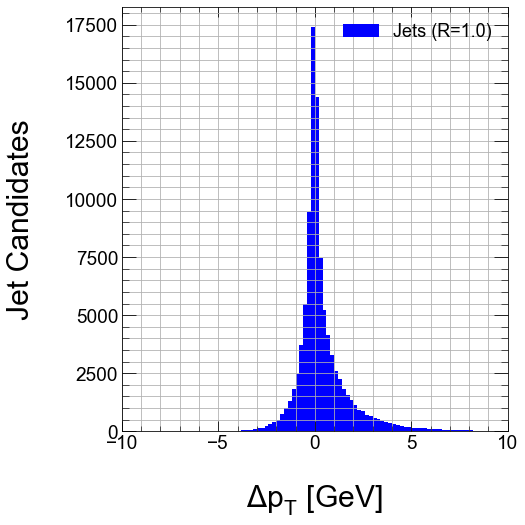

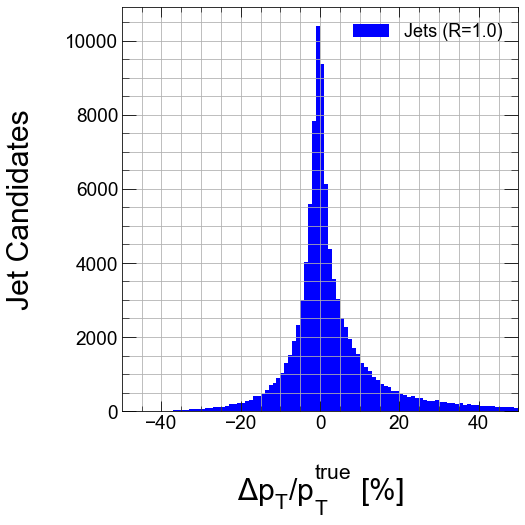

In [42]:
# Draw the jet resolutions (p_T, etc.)

jet_pt = np.concatenate(df['Jet.PT'].to_numpy()).ravel()
truejet_pt = np.concatenate(df['Jet.TruePt'].to_numpy()).ravel()

delta_pt = jet_pt - truejet_pt

hist(delta_pt,xlim=[-10,10], bins=100, label='Jets (R=1.0)', 
     xlabel="$\Delta p_T$ [GeV]", ylabel="Jet Candidates")

delta_pt_rel = delta_pt/truejet_pt*100

hist(delta_pt_rel,xlim=[-50,50], bins=100, label='Jets (R=1.0)', 
     xlabel="$\Delta p_T/p_T^{true}$ [%]", ylabel="Jet Candidates")


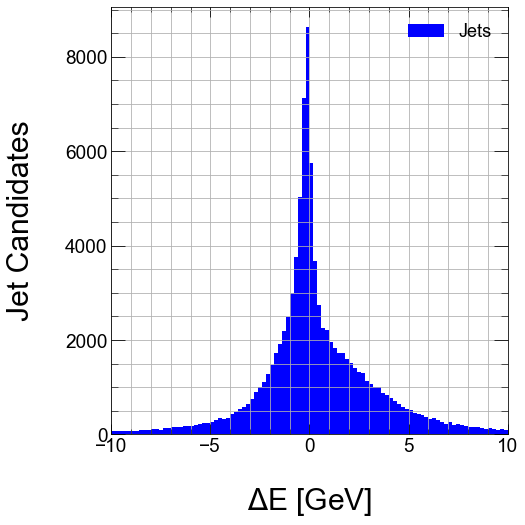

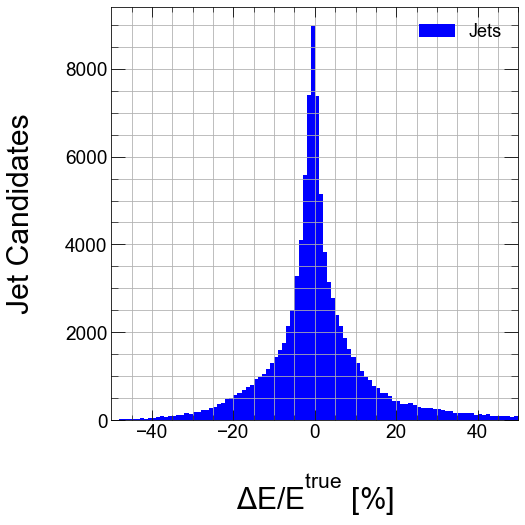

In [44]:
# Draw the jet energy resolution

jet_e = np.concatenate(df['Jet.E'].to_numpy()).ravel()
truejet_e = np.concatenate(df['Jet.TrueE'].to_numpy()).ravel()

delta_e = jet_e - truejet_e

hist(delta_e,xlim=[-10,10], bins=100, label='Jets', xlabel="$\Delta E$ [GeV]", ylabel="Jet Candidates")

delta_e_rel = delta_e/truejet_e*100

hist(delta_e_rel,xlim=[-50,50], bins=100, label='Jets', xlabel="$\Delta E/E^{true}$ [%]", ylabel="Jet Candidates")


### Jet Energy Resolution in Detector Regions

Below are plots of the jet energy resolution for jets that fall into the three regions of the detector described earlier: "barrel," "transition," and "endcap." Based on observations of $\Sigma_E$ above, a two-component analytic model is fitted to a binned distribution of the variable. One component models the narrow "core" region of the resolution distribution (using a Gaussian), while a second component models the wider "tail" region of the distribution (also a Gaussian, which is not an optimal choice but is fine for now). The model is fitted using SciPy's curve-fitting method, which employs a non-linear least squares to fit a function to the binned distribution. The core Gaussian width is quoted as the "core resolution," while the tail Gaussian width is quoted at the "tail resolution."

In [45]:
# Define function(s) for resolution studies
def resolution_model(x, x0, sigma0, x1, sigma1, A, f):
    return A * (f*np.exp(-(x-x0)**2/(2*sigma0**2)) + (1-f)*np.exp(-(x-x1)**2/(2*sigma1**2)))


def resolution_fit(df, reco_var, true_var, res_var, eta_range=[-10, 10], label="", show=True):
    reco_x = np.concatenate(df[reco_var].to_numpy()).ravel()
    true_x = np.concatenate(df[true_var].to_numpy()).ravel()

    jet_eta = np.concatenate(df['Jet.Eta'].to_numpy()).ravel()
    
    reco_x = reco_x[ (eta_range[0] < jet_eta) & (jet_eta < eta_range[-1]) ]
    true_x = true_x[ (eta_range[0] < jet_eta) & (jet_eta < eta_range[-1]) ]
    
    #delta_x = true_x - reco_x
    delta_x = reco_x - true_x
    delta_x_rel = delta_x/true_x*100

    fit_range = [-40, 40]
    nbins = 400

    [y,xbins] = np.histogram(delta_x_rel,range=fit_range, bins=nbins)
    x = xbins[:-1] + np.diff(xbins) / 2

    popt, pcov = scipy.optimize.curve_fit(resolution_model, x, y,
                                          p0 = (0, 5, 0, 7.5, len(delta_x_rel)/2, 0.5),
                                          bounds=([-100,0,-100, 0, 0, 0], [100,100,100,100,len(delta_x_rel),1.0]))

    #print(popt)

    perr=np.sqrt(np.diag(pcov))

    #print(perr)

    sigma0=popt[1]
    sigma0_err = perr[1]

    sigma1=popt[3]
    sigma1_err = perr[3]

    #sigma0s = np.append(sigma0s, [sigma0])
    #sigma0_errors = np.append(sigma0_errors, [sigma0_err])

    #sigma1s = np.append(sigma1s, [sigma1])
    #sigma1_errors = np.append(sigma1_errors, [sigma1_err])

    #bfields = np.append(bfields, [float(study_map[key].replace('T',''))])

    bias=popt[0]
    bias_err=perr[0]

    sigma0_text=f"core resolution: {sigma0:.2f}$\pm${sigma0_err:.2f} %"
    sigma1_text=f"tail resolution: {sigma1:.2f}$\pm${sigma1_err:.2f} %"
    bias_text  =f"bias:            {bias:.2f}$\pm${bias_err:.2f} %"

    text = f"{sigma0_text}\n{sigma1_text}"
    
    if show:
        # Tail Model Width
        fig, ax = plt.subplots(figsize=(8,8))
        plt.grid(which='both')
        ax1 = plt.hist(delta_x_rel, range=fit_range, bins=xbins, color='b', linewidth=3)
        ax2 = plt.plot(x, resolution_model(x, *popt), color='r', linewidth=3, label=label)

        ax.text(0.55, 0.75, text, fontsize=14, transform=ax.transAxes, ma='left',
                bbox=dict(boxstyle="round", ec=(
                          204 / 255, 0, 53 / 255), fc=(0.9, 0.9, 0.9))
                )


        plt.xlim(fit_range)
        plt.ylabel("Jet Candidates")
        plt.xlabel(f"{res_var} Resolution [%]")
        #ax.set_xscale('log')
        plt.legend()
        plt.tight_layout()
        plt.show()

    return {'parameters': popt, 'errors': perr}


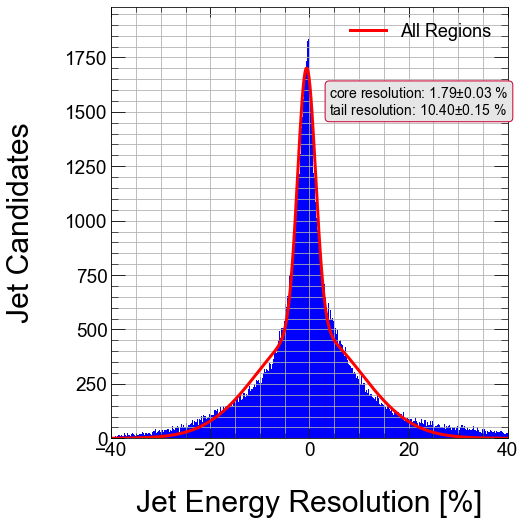

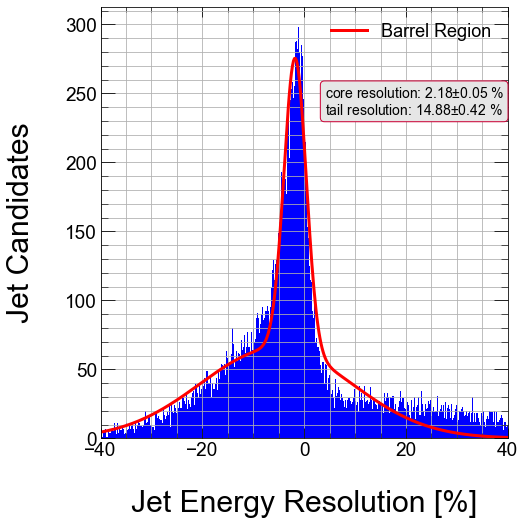

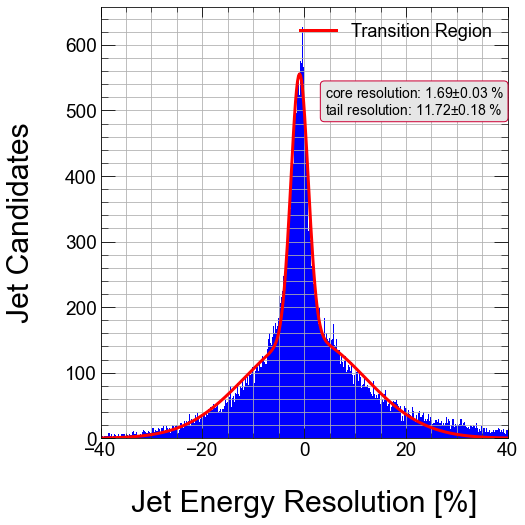

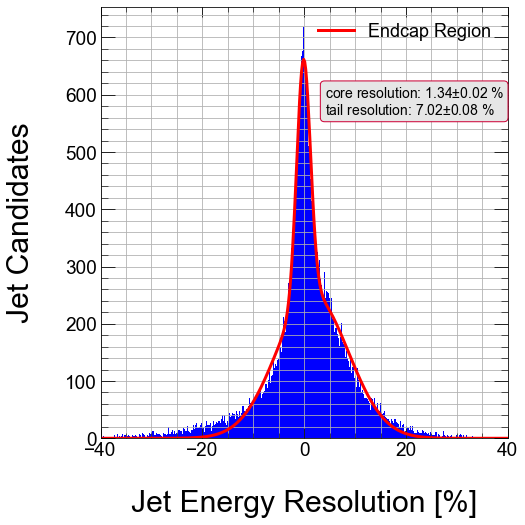

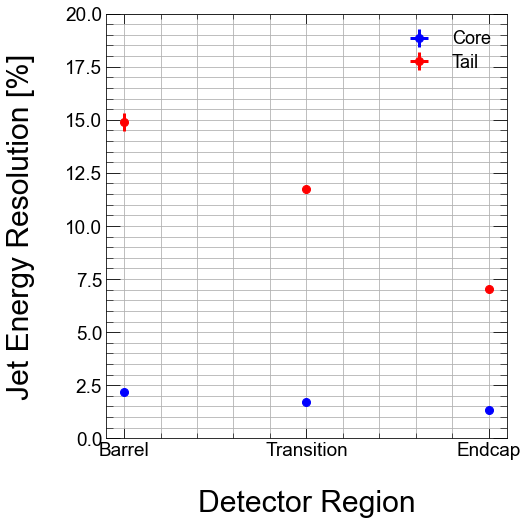

In [46]:
# Some resolution fits/studies

# All jets
resolution_fit(df, 'Jet.E', 'Jet.TrueE', 'Jet Energy', label="All Regions", show=True)

# Subsets of jets
global barrel_jet, transition_jet, endcap_jet
barrel_jet = [-0.5, 0.5]
transition_jet = [0.5, 1.5]
endcap_jet = [1.5, 2.5]

barrel_results = resolution_fit(df, 'Jet.E', 'Jet.TrueE', 'Jet Energy', 
                                eta_range=barrel_jet, label="Barrel Region", show=True)
transition_results = resolution_fit(df, 'Jet.E', 'Jet.TrueE', 'Jet Energy', 
                                    eta_range=transition_jet, label="Transition Region", show=True)
endcap_results = resolution_fit(df, 'Jet.E', 'Jet.TrueE', 'Jet Energy', 
                                eta_range=endcap_jet, label="Endcap Region", show=True)


# Resolution vs. Region

core_res_val = np.array([barrel_results['parameters'][1], 
                        transition_results['parameters'][1],
                        endcap_results['parameters'][1]])

core_res_err = np.array([barrel_results['errors'][1], 
                        transition_results['errors'][1],
                        endcap_results['errors'][1]])

tail_res_val = np.array([barrel_results['parameters'][3], 
                        transition_results['parameters'][3],
                        endcap_results['parameters'][3]])

tail_res_err = np.array([barrel_results['errors'][3], 
                        transition_results['errors'][3],
                        endcap_results['errors'][3]])

region_names = np.array(['Barrel', 'Transition', 'Endcap'])
regions = np.array([1,2,3])

fig, ax = plt.subplots(figsize=(8,8))
plt.grid(which='both')
plt.errorbar(x=regions, y=core_res_val, xerr=0, yerr=core_res_err, 
             color='b', linewidth=3, fmt='bo', ls='none', label='Core')
plt.errorbar(x=regions, y=tail_res_val, xerr=0, yerr=tail_res_err, 
             color='r', linewidth=3, fmt='ro', ls='none', label='Tail')
#plt.xlim([0.5, 4.0])
plt.ylim([0.0, 20.0])
plt.ylabel(f"Jet Energy Resolution [%]")
plt.xlabel("Detector Region")
ax.set_xticks(regions)
ax.set_xticklabels(region_names)
#ax.set_xscale('log')
plt.legend()
plt.tight_layout()
plt.show()


## Energy Resolution vs. Jet Energy

Miguel noted that the behavior above - improving resolution in jet energy - could be due to the increased endcap calorimeter granularity compared to the barrel. While tracking efficiency and resolution degrades with increasing $|\eta|$, ECAL granularity improves significantly. The granularity in $\eta$ is constant at steps of 0.02, but in polar-angle space this represents *increasing* granularity with *increasing* $|\eta|$. For example, in the barrel the polar angular resolution of the calorimeter is about 1 degree, while in the endcap it's about 0.5 degrees. So this can compensate for the loss in tracking resolution and efficiency, which would otherwise have an effect on energy flow jet reconstruction and jet resolution.

To study this in more detail, the resolution ($\Sigma$) is broken down as a function of jet energy as well as detector region. We can clearly see the worse resolution overall for low-energy jets, while at high energy (which puts most of the jets forward) the resolution is similar between the "transition" region and the fiducial endcap region.

### All Jets

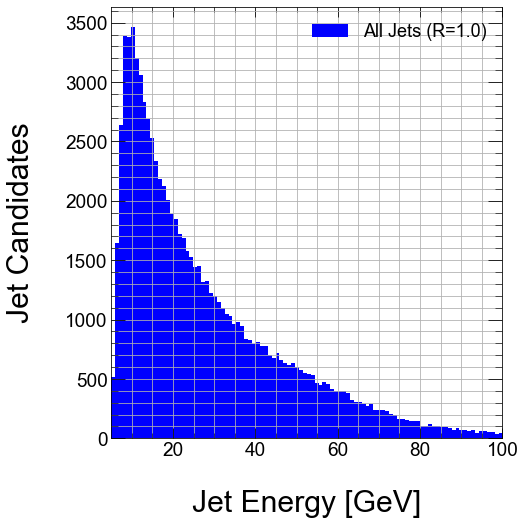

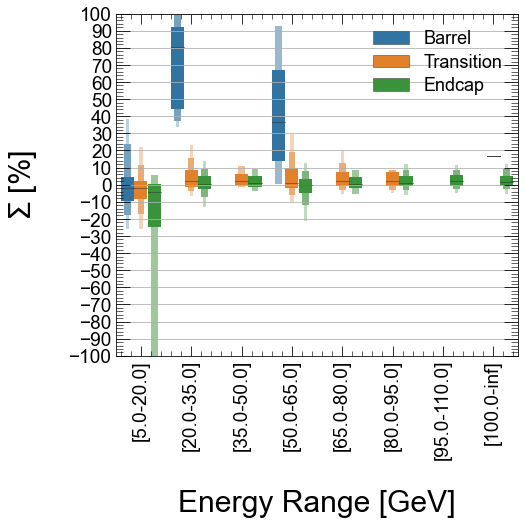

In [57]:
# Barrel region vs. Jet Energy
def setJetEnergyRange(energy, jet_ranges):
    for bucket in jet_ranges:
        if jet_ranges[bucket][0] <= energy < jet_ranges[bucket][1]:
            return bucket

def setJetRegion(eta, regions):
    for region in regions:
        if regions[region][0] <= eta < regions[region][1]:
            return region
    return "Other"
        
def jetResolutionVsX(df, reco_var, true_var, region_etas=None, min_x=0.0, max_x=100.0, step_x=10.0):
    global barrel_jet, transition_jet, endcap_jet

    reco_x = np.concatenate(df[reco_var].to_numpy()).ravel()
    true_x = np.concatenate(df[true_var].to_numpy()).ravel()

    # 1-D plot of the variable in this region of eta
    jet_eta = np.concatenate(df['Jet.Eta'].to_numpy()).ravel()
    
    
    # Restrict to overall eta range
    fiducial_cut = (barrel_jet[0] < jet_eta) & (jet_eta < endcap_jet[1])
    reco_x  = reco_x[fiducial_cut]
    true_x  = true_x[fiducial_cut]
    jet_eta = jet_eta[fiducial_cut]
    
    eta_cut = np.ones(len(jet_eta), dtype=bool)
    if region_etas != None:
        eta_cut = (region_etas[0] < jet_eta) &  (jet_eta < region_etas[1])
    
    label = "All Jets (R=1.0)"
    if region_etas != None:
        label = f"Jets $\eta$=[{region_etas[0]}, {region_etas[1]}] (R=1.0)"
        
    hist(reco_x[eta_cut],[min_x,max_x], 100, 
         label=label, xlabel="Jet Energy [GeV]", ylabel="Jet Candidates")

    x_resolution = (reco_x - true_x)/true_x * 100.0

    # Bucket the data in x 
    x_ranges = {}
    jet_E_min = min_x
    jet_E_max = max_x
    jet_E_binsize = step_x
    for jet_min in np.arange(jet_E_min, jet_E_max, jet_E_binsize):
        x_ranges[f"[{jet_min}-{jet_min+jet_E_binsize}]"] = [jet_min, jet_min+jet_E_binsize]

    # overflow bin
    x_ranges[f"[{jet_E_max}-inf]"] = [jet_E_max, jet_E_max+10000.0]


    # Bucket the jet energies
    vEnergyRanges = np.vectorize(setJetEnergyRange)

    # Bucket the data also in region of the detector
    detector_ranges = {'Barrel': barrel_jet,
                       'Transition': transition_jet,
                       'Endcap': endcap_jet}
    
    vJetRegions = np.vectorize(setJetRegion)

    # Setup the data structure
    region_jets = {}
    if region_etas != None:
        region_jets = {'x_resolution': x_resolution[ eta_cut],
                      'x': vEnergyRanges(reco_x[eta_cut], x_ranges),
                      'region': vJetRegions(jet_eta[eta_cut], detector_ranges)}
    else:
        region_jets = {'x_resolution': x_resolution,
                      'x': vEnergyRanges(reco_x, x_ranges),
                      'region': vJetRegions(jet_eta, detector_ranges)}
    
 
    region_names = np.array(list(x_ranges.keys()))
    regions = np.arange(0,len(region_names),1)

    fig, ax = plt.subplots(figsize=(8,8))
    plt.grid(which='major', axis='y')
    if region_etas != None:
        ax = sns.boxenplot(x="x", y="x_resolution", data=region_jets, palette="GnBu_d",
                          outlier_prop=0.317, showfliers=False)
    else:
        ax = sns.boxenplot(x="x", y="x_resolution", data=region_jets, hue='region', 
                           outlier_prop=0.317, showfliers=False)

    #plt.xlim([5, 100])
    plt.ylim([-100.0, 100.0])
    plt.ylabel(f"$\Sigma$ [%]")
    plt.xlabel("Energy Range [GeV]")
    ax.set_xticks(regions)
    ax.set_xticklabels(region_names, rotation = 90, ha='center')
    plt.yticks(np.arange(-100, 101, 10.0))
    #ax.set_xscale('log')
    if region_etas == None:
        plt.legend()
    plt.tight_layout()
    plt.show()
    
jetResolutionVsX(df, 'Jet.E', 'Jet.TrueE', None, 5.0, 100.0, 15.0)

### Barrel Jets Only

These have a very soft spectrum; nearly all jets have energy less than 30 GeV. The resolution is fine-grained here in bins of jet energy.

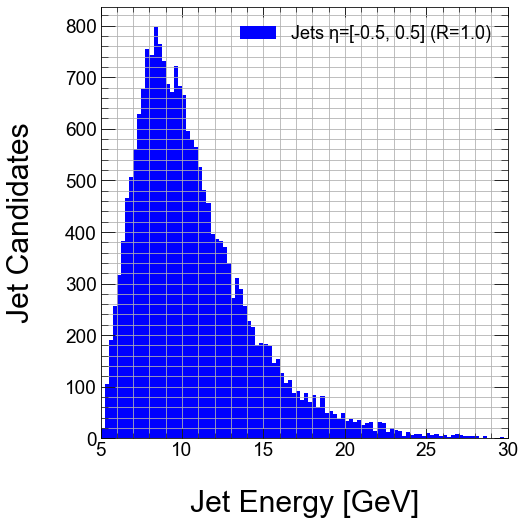

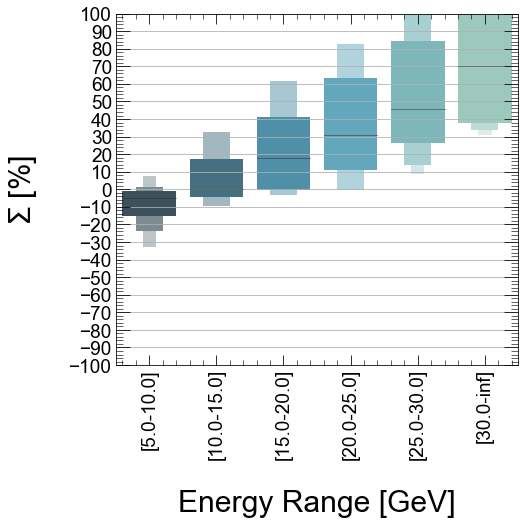

In [58]:
jetResolutionVsX(df, 'Jet.E', 'Jet.TrueE', barrel_jet, 5.0, 30.0, 5.0)

### Transition Region Jets Only

These jets have a harder spectrum that overlaps better with the endcap jets (which represent the hardest jet spectrum).

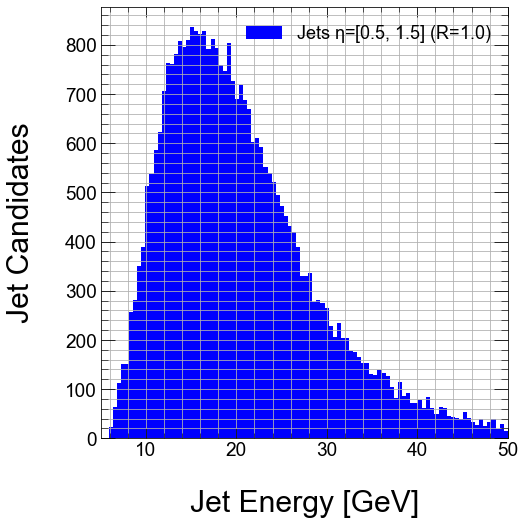

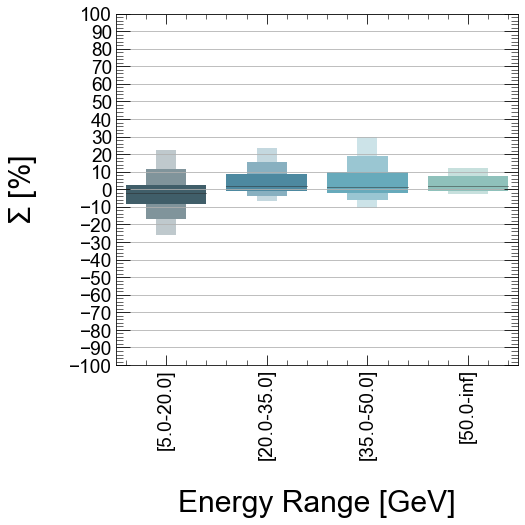

In [59]:
jetResolutionVsX(df, 'Jet.E', 'Jet.TrueE', transition_jet, 5.0, 50.0, 15.0)

### Endcap Region Jets Only

These have the overall hardest spectrum, with a signficant tail that runs up to  about 100 GeV.

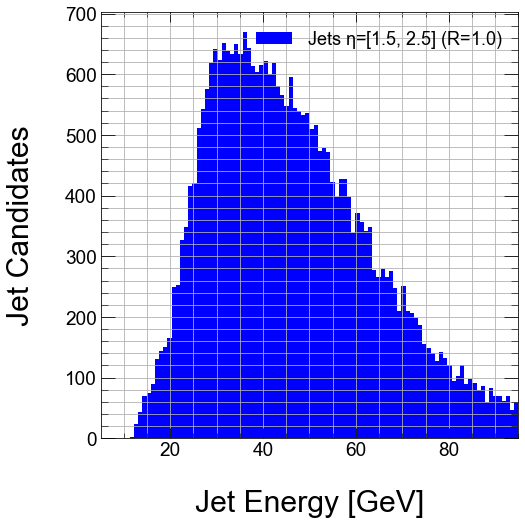

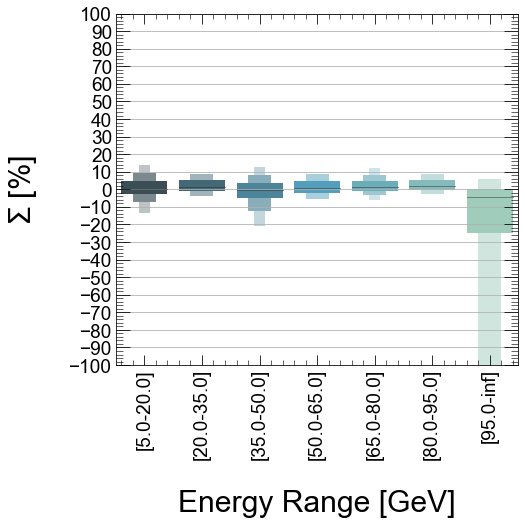

In [60]:
jetResolutionVsX(df, 'Jet.E', 'Jet.TrueE', endcap_jet, 5.0, 95.0, 15.0)

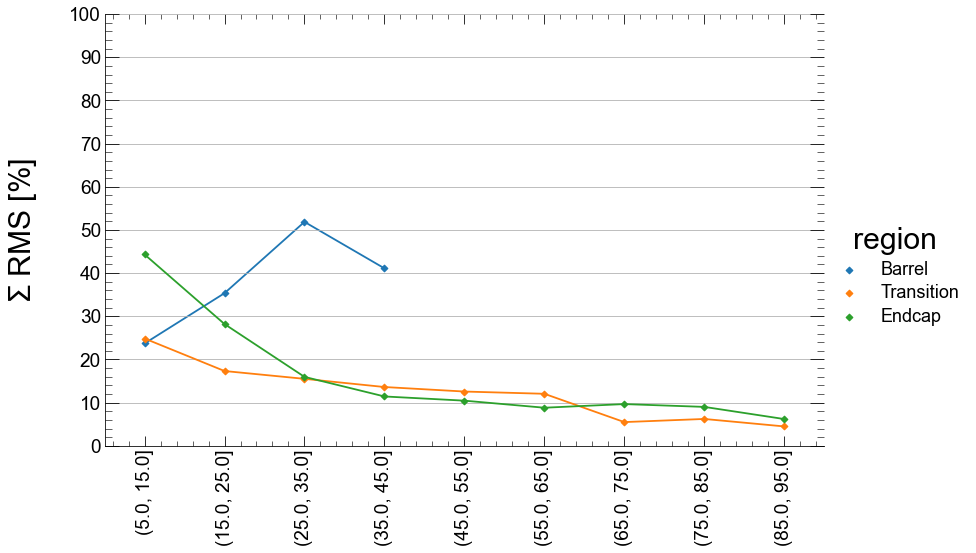

In [140]:
def jetRMSVsX(df, reco_var, true_var, region_etas=None, min_x=0.0, max_x=100.0, step_x=10.0):
    global barrel_jet, transition_jet, endcap_jet

    reco_x = np.concatenate(df[reco_var].to_numpy()).ravel()
    true_x = np.concatenate(df[true_var].to_numpy()).ravel()

    # 1-D plot of the variable in this region of eta
    jet_eta = np.concatenate(df['Jet.Eta'].to_numpy()).ravel()
    
    
    # Restrict to overall eta range
    fiducial_cut = (barrel_jet[0] < jet_eta) & (jet_eta < endcap_jet[1])
    reco_x  = reco_x[fiducial_cut]
    true_x  = true_x[fiducial_cut]
    jet_eta = jet_eta[fiducial_cut]
    
    jet_df = pd.DataFrame.from_dict({'reco_x': reco_x,
                                    'true_x': true_x,
                                    'jet_eta': jet_eta})
    jet_df['x_resolution'] = 100*(jet_df['reco_x'] - jet_df['true_x'])/jet_df['true_x']

    detector_regions = [-0.5, 0.5, 1.5, 2.5]
    region_names = ['Barrel', 'Transition', 'Endcap']
    
    jet_df['region'] = pd.cut(jet_df['jet_eta'], detector_regions, labels=region_names)

    
    x_regions = []
    for jet_min in np.arange(min_x, max_x, step_x):
        x_regions.append(jet_min)
    x_regions.append(max_x)
    

    jet_df['x_bin'] = pd.cut(jet_df['reco_x'], x_regions)

    
    plot_data = jet_df.groupby(['x_bin','region'], as_index=False, observed=True).var()
    plot_data['x_resolution'] = np.sqrt(plot_data['x_resolution'])

    g = sns.catplot(x="x_bin", y="x_resolution",
                hue="region", 
                data=plot_data, kind="point",
                height=8, aspect=1.5,
                markers="D",
                despine=False);
    (g.set_axis_labels("", f"$\Sigma$ RMS [%]")
      .set_titles("{col_name} {col_var}")
      .set(ylim=(0, 100)))
    [plt.setp(ax.get_xticklabels(), rotation=90) for ax in g.axes.flat]
    [plt.grid(which='major', axis='y') for ax in g.axes.flat]
    [plt.yticks(np.arange(0, 101, 10.0)) for ax in g.axes.flat]

jetRMSVsX(df, 'Jet.E', 'Jet.TrueE', None, 5.0, 95.0, 10.0)

### Observations: Energy Resolution Study

1. Energy resolution is poor at low jet energy (e.g. $E<30$GeV) compared to harder jets.
2. The increasing polar angle granularity of the endcap may be compensating for the decreasing tracking resolution and efficiency as $|\eta|$ grows.
3. For this simulation, endcap and transition region energy resolutions appear to be comparable in regions with large jet populations (e.g. where statistical uncertainties are smaller).

\newpage

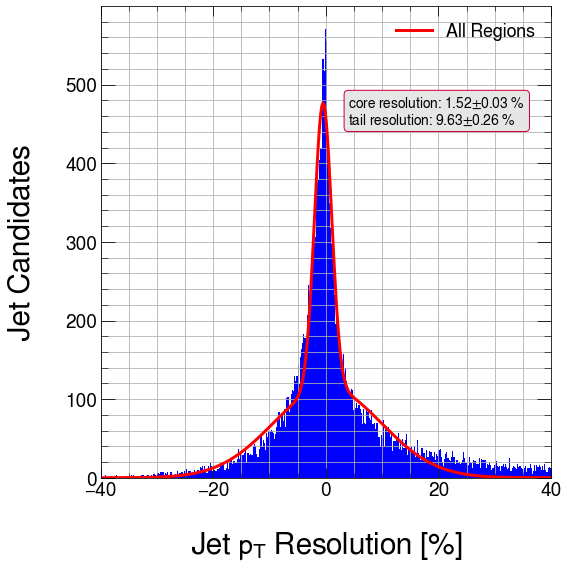

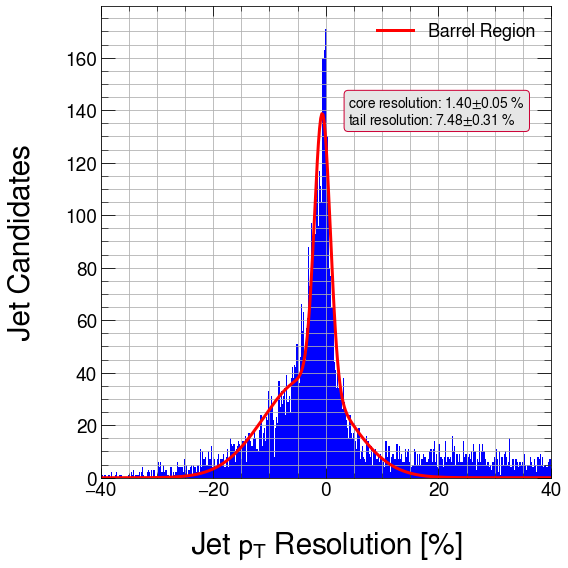

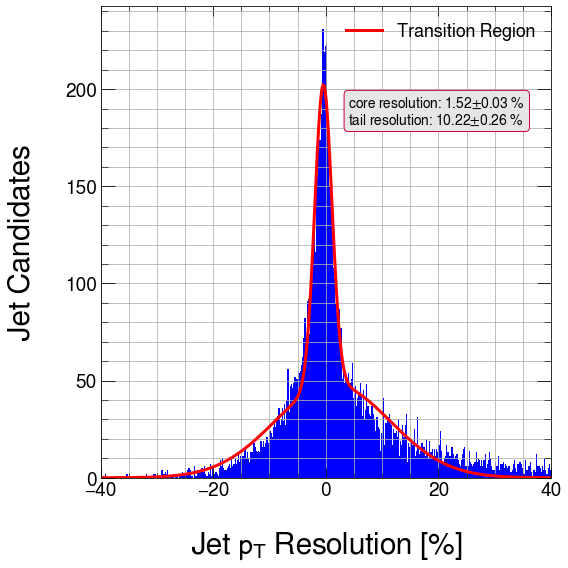

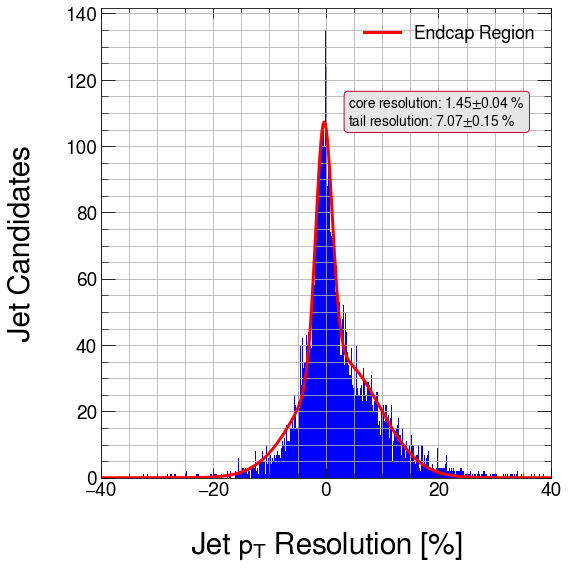

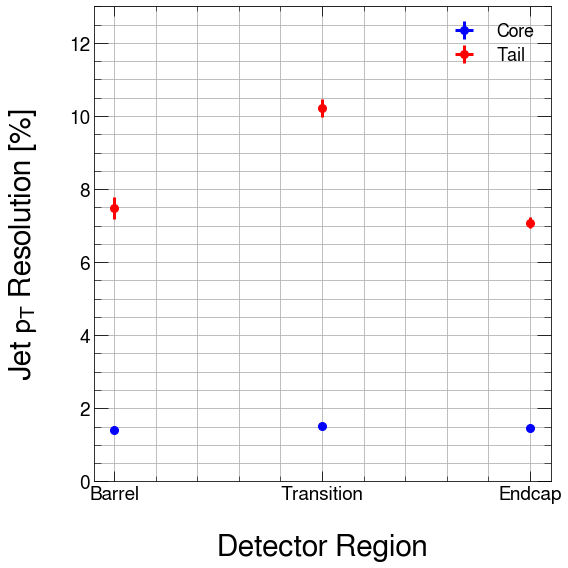

In [17]:
# Jet PT resolution fits/studies

# All jets
resolution_fit(df, 'Jet.PT', 'Jet.TruePt', 'Jet $p_T$', label="All Regions", show=True)

# Subsets of jets
barrel_jet = [-0.5, 0.5]
transition_jet = [0.5, 1.5]
endcap_jet = [1.5, 2.5]

barrel_results = resolution_fit(df, 'Jet.PT', 'Jet.TruePt', 'Jet $p_T$', 
                                eta_range=barrel_jet, label="Barrel Region", show=True)
transition_results = resolution_fit(df, 'Jet.PT', 'Jet.TruePt', 'Jet $p_T$', 
                                    eta_range=transition_jet, label="Transition Region", show=True)
endcap_results = resolution_fit(df, 'Jet.PT', 'Jet.TruePt', 'Jet $p_T$', 
                                eta_range=endcap_jet, label="Endcap Region", show=True)


# Resolution vs. Region

core_res_val = np.array([barrel_results['parameters'][1], 
                        transition_results['parameters'][1],
                        endcap_results['parameters'][1]])

core_res_err = np.array([barrel_results['errors'][1], 
                        transition_results['errors'][1],
                        endcap_results['errors'][1]])

tail_res_val = np.array([barrel_results['parameters'][3], 
                        transition_results['parameters'][3],
                        endcap_results['parameters'][3]])

tail_res_err = np.array([barrel_results['errors'][3], 
                        transition_results['errors'][3],
                        endcap_results['errors'][3]])

region_names = np.array(['Barrel', 'Transition', 'Endcap'])
regions = np.array([1,2,3])

fig, ax = plt.subplots(figsize=(8,8))
plt.grid(which='both')
plt.errorbar(x=regions, y=core_res_val, xerr=0, yerr=core_res_err, 
             color='b', linewidth=3, fmt='bo', ls='none', label='Core')
plt.errorbar(x=regions, y=tail_res_val, xerr=0, yerr=tail_res_err, 
             color='r', linewidth=3, fmt='ro', ls='none', label='Tail')
#plt.xlim([0.5, 4.0])
plt.ylim([0.0, 13.0])
plt.ylabel(f"Jet $p_T$ Resolution [%]")
plt.xlabel("Detector Region")
ax.set_xticks(regions)
ax.set_xticklabels(region_names)
#ax.set_xscale('log')
plt.legend()
plt.tight_layout()
plt.show()


### Observations: $p_T$ Resolution Study

At least one observation is now possible.

1. The $p_T$ resolution behaves more as I would have expected - the transition region shows a degradation of resolution, with especially larger tails in the distribution.
2. However, I am still concerned that the endcap region performs almost as well, since here tracking performance is really degrading but nonetheless we still see a comparable resolution to the barrel. 

\newpage

## B-Field Strength and Resolution Study

In [13]:
study_map = {0: '1.0T', 1: '1.5T', 2: '2.0T', 3: '2.5T', 4: '3.0T', 5: '3.5T'}
datasets = {}


for key in study_map:
    print(f"Processing the {study_map[key]} setting data.")
    data = uproot.pandas.iterate([f"../bfield/{key}/out.root"], 
                               "Delphes", 
                               branches=["Jet*", "GenJet*"],
                              flatten=False)
    df_list = []
    for dataframe in data:
        df_list.append(dataframe)
    
    df = pd.concat(df_list)
    datasets[key] = df
    
print("Done loading data for the study!")

Processing the 1.0T setting data.
Processing the 1.5T setting data.
Processing the 2.0T setting data.
Processing the 2.5T setting data.
Processing the 3.0T setting data.
Processing the 3.5T setting data.
Done loading data for the study!


In [14]:
# Add auxiliary data
for key in study_map:
    df = datasets[key]
    df["Jet.TruePt"] = df.apply(TruthJetPt, axis=1)
    df["Jet.TrueE"] = df.apply(TruthJetE, axis=1)
    df["Jet.E"] = df.apply(JetEnergy, axis=1)


In [15]:
# Get the jet pT resolution for each B-Field setting

def resolution_study(reco_var, true_var, res_var, show=True):
    sigma0s = np.array([])
    sigma0_errors = np.array([])
    sigma1s = np.array([])
    sigma1_errors = np.array([])
    bfields = np.array([])

    for key in study_map:
        df = datasets[key]
        reco_x = np.concatenate(df[reco_var].to_numpy()).ravel()
        true_x = np.concatenate(df[true_var].to_numpy()).ravel()

        delta_x = true_x - reco_x
        delta_x_rel = delta_x/true_x*100

        fit_range = [-40, 40]
        nbins = 400

        [y,xbins] = np.histogram(delta_x_rel,range=fit_range, bins=nbins)
        x = xbins[:-1] + np.diff(xbins) / 2

        popt, pcov = scipy.optimize.curve_fit(resolution_model, x, y,
                                              p0 = (0, 5, 0, 7.5, len(delta_x_rel)/2, 0.5),
                                              bounds=([-100,0,-100, 0, 0, 0], [100,100,100,100,len(delta_x_rel),1.0]))

        #print(popt)

        perr=np.sqrt(np.diag(pcov))

        #print(perr)

        sigma0=popt[1]
        sigma0_err = perr[1]

        sigma1=popt[3]
        sigma1_err = perr[3]

        sigma0s = np.append(sigma0s, [sigma0])
        sigma0_errors = np.append(sigma0_errors, [sigma0_err])

        sigma1s = np.append(sigma1s, [sigma1])
        sigma1_errors = np.append(sigma1_errors, [sigma1_err])

        bfields = np.append(bfields, [float(study_map[key].replace('T',''))])

        bias=popt[0]
        bias_err=perr[0]

        sigma_text=f"{res_var} resolution: {sigma0:.2f}$\pm${sigma0_err:.2f} %"
        bias_text=f"{res_var} bias:       {bias:.2f}$\pm${bias_err:.2f} %"
        print(sigma_text)
        print(bias_text)

        # Tail Model Width
        fig, ax = plt.subplots(figsize=(8,8))
        plt.grid(which='both')
        plt.hist(delta_x_rel, range=fit_range, bins=xbins, color='b', linewidth=3, 
                 label=f'Simulation ($B_z=${study_map[key]})')
        plt.plot(x, resolution_model(x, *popt), color='r', linewidth=3, label='Model')

        plt.xlim(fit_range)
        plt.ylabel("Jet Candidates")
        plt.xlabel(f"{res_var} Resolution [%]")
        #ax.set_xscale('log')
        plt.legend()
        plt.tight_layout()
        plt.show()
        
    # Core Model Width
    fig, ax = plt.subplots(figsize=(8,8))
    plt.grid(which='both')
    plt.errorbar(x=bfields, y=sigma0s, xerr=0.25, yerr=sigma0_errors, 
                 color='b', linewidth=3, fmt='bo', ls='none')
    plt.xlim([0.5, 4.0])
    plt.ylim([0.0, 4.0])
    plt.ylabel(f"{res_var} Core Resolution [%]")
    plt.xlabel("Solenoidal Magnetic Field Strength $B_z$ [T]")
    #ax.set_xscale('log')
    plt.tight_layout()
    if show:
        plt.show()

    # Tail Model Width
    fig, ax = plt.subplots(figsize=(8,8))
    plt.grid(which='both')
    plt.errorbar(x=bfields, y=sigma1s, xerr=0.25, yerr=sigma1_errors, 
                 color='b', linewidth=3, fmt='ro', ls='none')
    plt.xlim([0.5, 4.0])
    plt.ylim([0.0, 20.0])
    plt.ylabel(f"{res_var} Tails Resolution [%]")
    plt.xlabel("Solenoidal Magnetic Field Strength $B_z$ [T]")
    #ax.set_xscale('log')
    plt.tight_layout()
    if show:
        plt.show()

#print(sigma0s)
#print(sigma1s)
#print(bfields)



Jet $p_T$ resolution: 1.62$\pm$0.03 %
Jet $p_T$ bias:       0.48$\pm$0.03 %


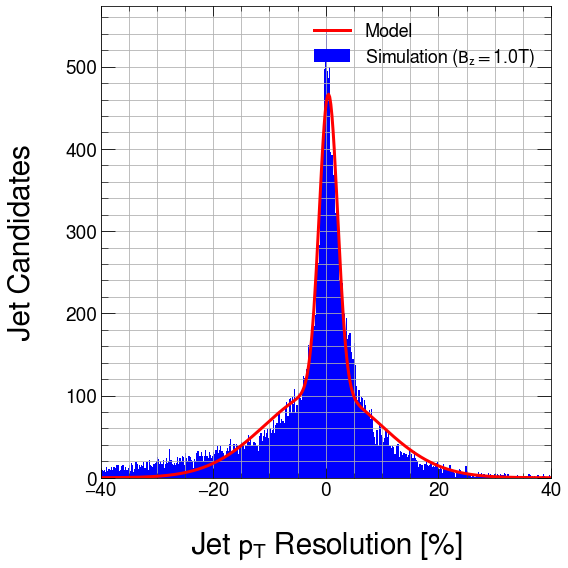

Jet $p_T$ resolution: 1.52$\pm$0.03 %
Jet $p_T$ bias:       0.48$\pm$0.03 %


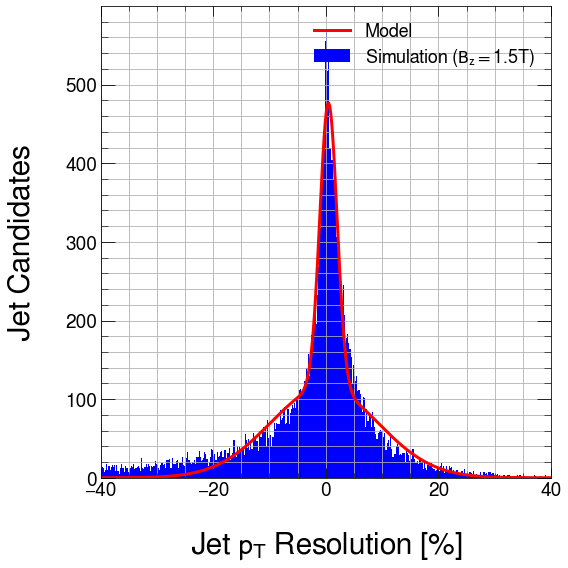

Jet $p_T$ resolution: 1.62$\pm$0.03 %
Jet $p_T$ bias:       0.47$\pm$0.03 %


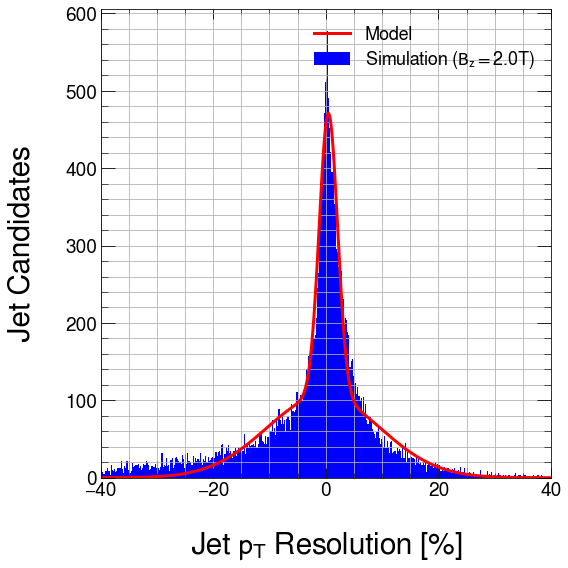

Jet $p_T$ resolution: 1.67$\pm$0.04 %
Jet $p_T$ bias:       0.48$\pm$0.03 %


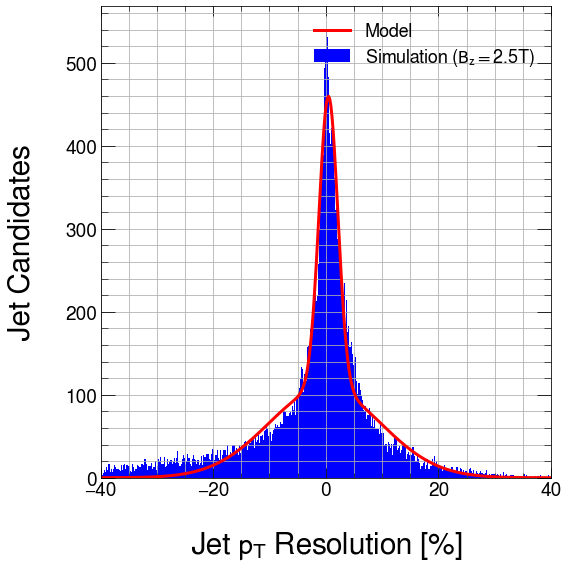

Jet $p_T$ resolution: 1.64$\pm$0.03 %
Jet $p_T$ bias:       0.55$\pm$0.03 %


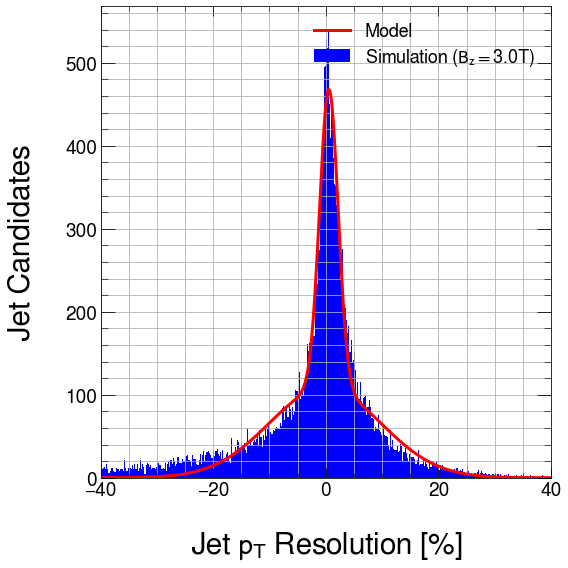

Jet $p_T$ resolution: 1.67$\pm$0.03 %
Jet $p_T$ bias:       0.52$\pm$0.02 %


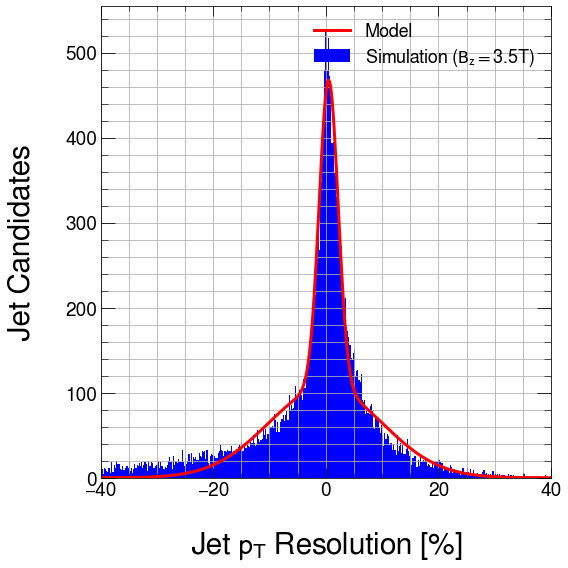

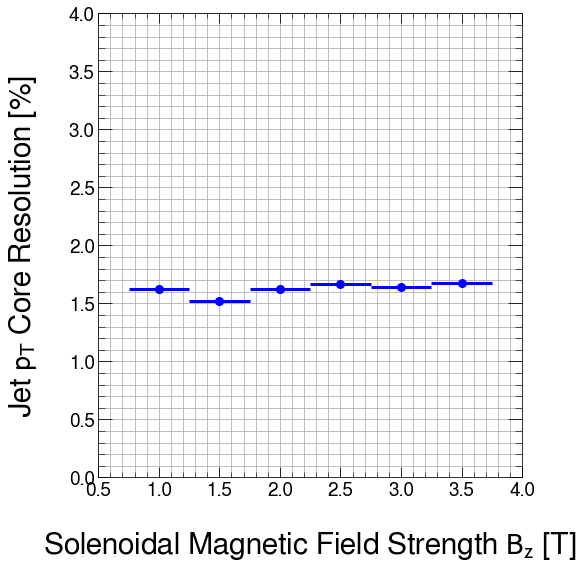

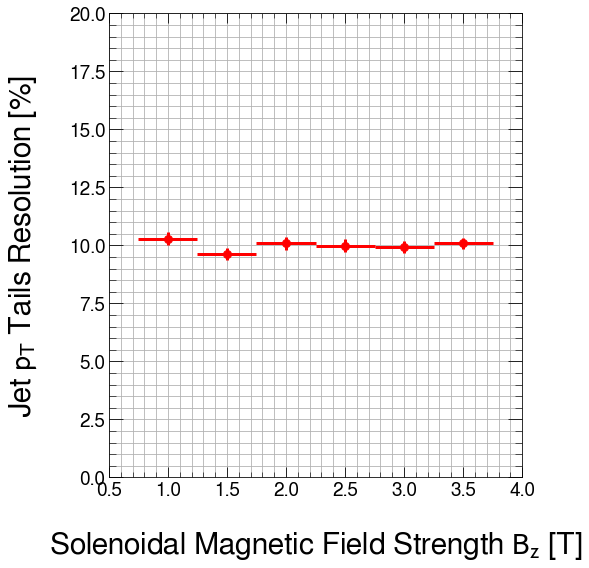

In [16]:
# pt resolution study
reco_var = 'Jet.PT'
true_var = 'Jet.TruePt'
res_var = 'Jet $p_T$'

resolution_study(reco_var, true_var, res_var)

Jet Energy resolution: 1.81$\pm$0.03 %
Jet Energy bias:       0.90$\pm$0.03 %


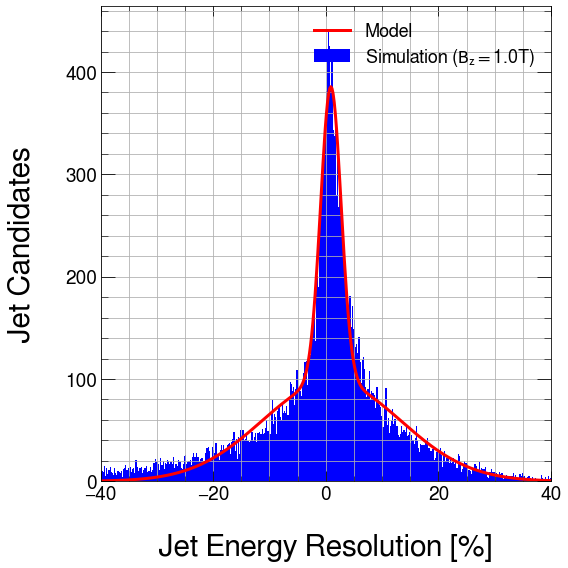

Jet Energy resolution: 1.82$\pm$0.03 %
Jet Energy bias:       0.93$\pm$0.03 %


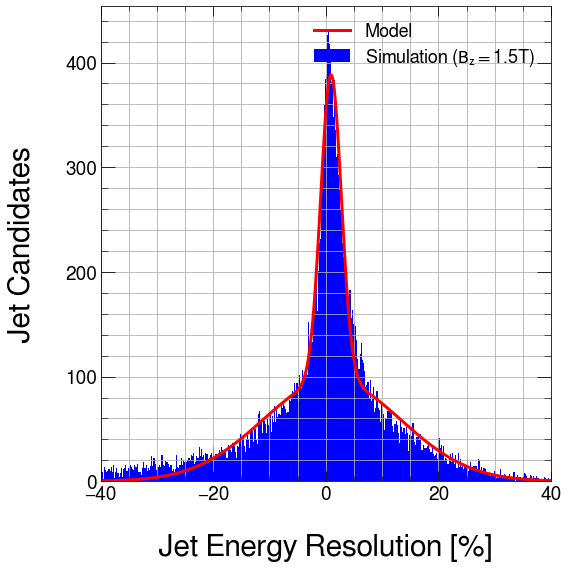

Jet Energy resolution: 1.90$\pm$0.03 %
Jet Energy bias:       0.95$\pm$0.03 %


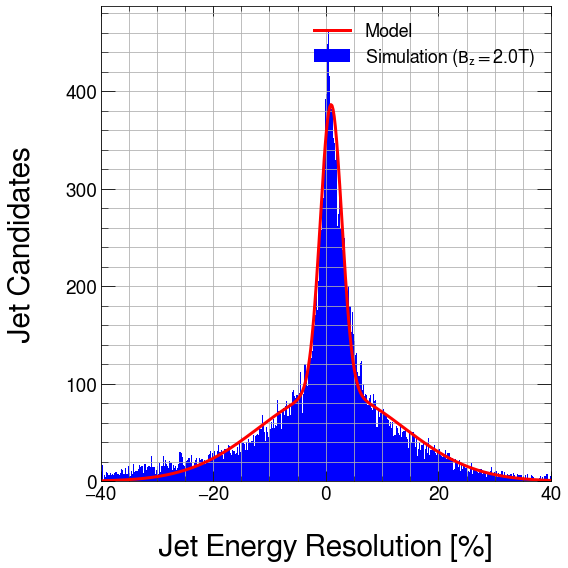

Jet Energy resolution: 1.93$\pm$0.03 %
Jet Energy bias:       0.91$\pm$0.03 %


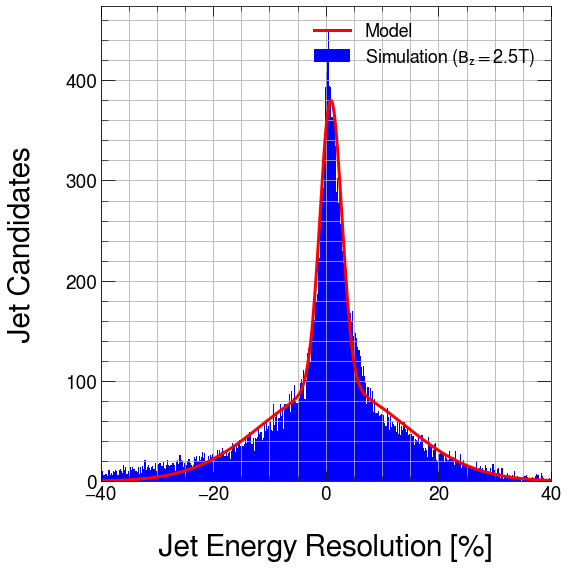

Jet Energy resolution: 1.86$\pm$0.03 %
Jet Energy bias:       0.99$\pm$0.03 %


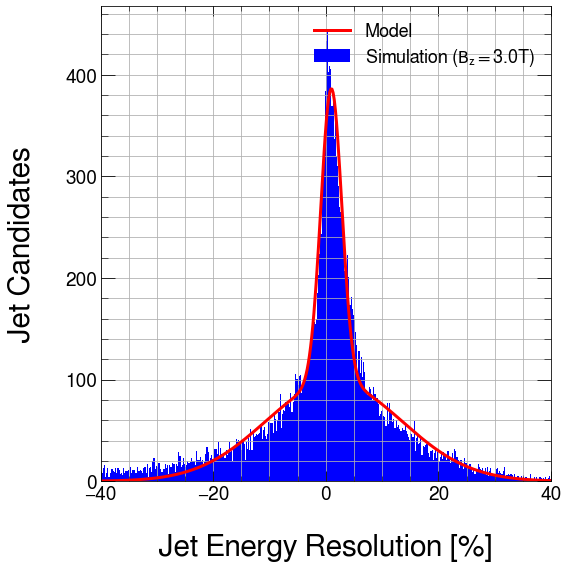

Jet Energy resolution: 1.91$\pm$0.03 %
Jet Energy bias:       1.00$\pm$0.03 %


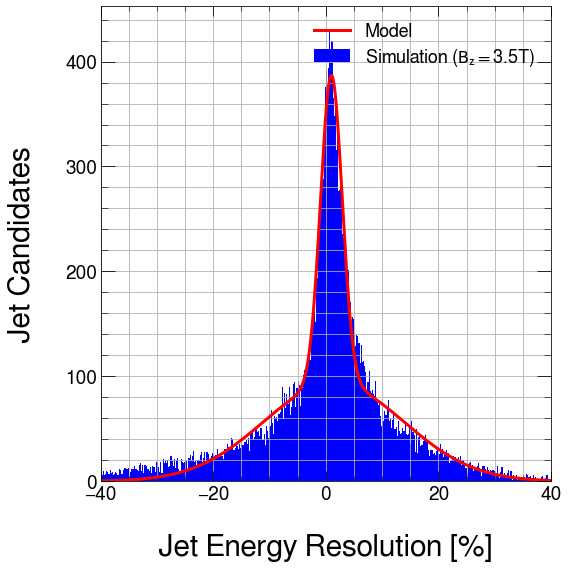

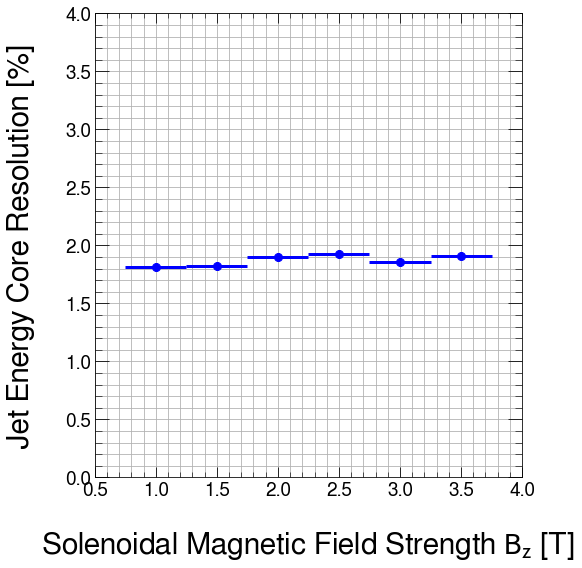

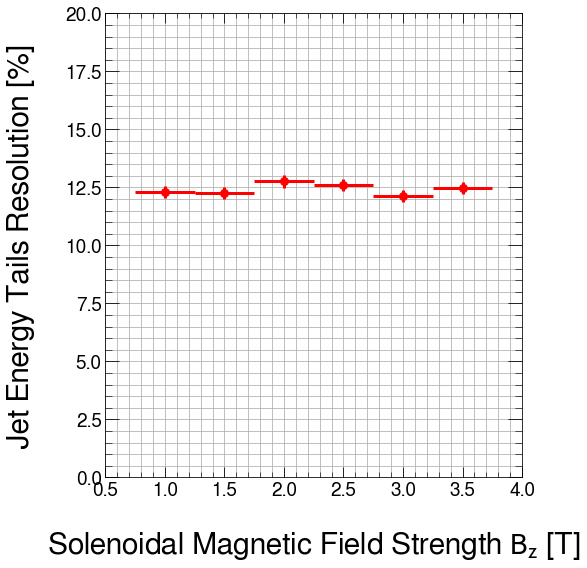

In [17]:
# energy resolution study
reco_var = 'Jet.E'
true_var = 'Jet.TrueE'
res_var = 'Jet Energy'

resolution_study(reco_var, true_var, res_var)